## Set UP

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%pip install wbdata
import wbdata
%pip install cufflinks
import cufflinks as cf
%pip install geopandas
import geopandas as gpd
import rasterio
import rasterio.plot
import IPython
cf.go_offline()

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Set Population Source

In [27]:
#wbdata.get_source() to get all sources
#wbdata.get_topic()
#wbdata.get_indicators()

source_id = 40 #Population Estimates and Projections
indicator=wbdata.get_indicators(source=40)

## Search Place Code
The following is the example to search the place code for 'world'.

In [28]:
###change the term 'world' in the function to search the code for the place/region/country that you are interested in
wbdata.get_countries(query='world')

id    name
----  ----------
ARB   Arab World
WLD   World

# Deliverables

## 1. [A] Population Dataframes
A function that returns a pandas DataFrame indexed by Region or Country and Year, with columns giving counts of people in different age-sex groups.


#### Variables Clarification

population_df(year, sex, age_range, place_code):
<br>
year: 1960 to 2050 (projections)
<br>
sex: "male"/ "female"/ "all"
<br>
age_range: accepts a list of two integers which should be or will be rounded to nearest multiplers of 5; and includes first rounded integer but exludes the second 
<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;(ex. [0, 8] aging from 0 inclusive to 10 exclusive)
<br>
place_code: accepts country/region/place code


In [29]:
"""
population age ranges available from dataset:
00-04, 05-09, 10-14, 15-19, 20-24, 25-29, 30-34, ..., 70-74, 75-79, above 80
"""

def population_df(year=2000, sex='all', age_range=(0, 80), place_code='WLD'):
    ##get all five-year age groups from rounded age_range 
    age_ranges=age_list(age_range)
    male_variables = {"SP.POP."+i+".MA":"{}-{}".format(i[:2], i[2:]) for i in age_ranges}
    female_variables = {"SP.POP."+i+".FE":"{}-{}".format(i[:2], i[2:]) for i in age_ranges}
    male_population = get_population_data(year, male_variables, 'male', place_code)
    female_population = get_population_data(year, female_variables, 'female', place_code)
    if sex=='male':
        df=male_population
    elif sex=='female':
        df=female_population
    else:  
        df=male_population.merge(female_population, on="age").set_axis(male_population.index)
        total_pop = df["female"] + df["male"]
        df["total"] = total_pop
    return df


def get_population_data(year, variables, gender, place_code):
    population_data = wbdata.get_dataframe(variables, country=place_code)
    population_data.index = population_data.index.astype(int)
    population_data.reset_index(inplace=True)
    population_data = population_data[population_data['date']==year].melt(id_vars=["date"], var_name="age", value_name=gender)
    population_data['place'] = place_code
    population_data.set_index(['place', 'date'], inplace=True)
    return population_data



##age_list function returns a list of five-year age group strings from rounded age_range       
def age_list(age_range):
    #round age_range to nearst multiples of five 
    def round_age(age_range):
        for i in range(0,2):
            if 0<age_range[i]%5<3:
                age_range[i]-=age_range[i]%5
                i+=1
            elif age_range[i]%5>=3:
                age_range[i]+=(5-age_range[i]%5)
                i+=1
            else:
                i+=1
        return age_range
    results = []
    age_lb, age_ub = round_age(age_range) 
    while age_lb < min(79, age_ub):
        results.append("{:02d}{:02d}".format(age_lb, age_lb + 4))
        age_lb += 5
    if age_lb >= 80:
        results.append('80UP')
    return results   

###  World 2000 Population Dataframe (if you encounter the error, please restart the kernel)

In [30]:
world_pop = population_df(year=2000, sex='all', age_range=(0, 80), place_code='WLD')
world_pop

age         male       female        total
place date                                              
WLD   2000  00-04  319947454.0  299176185.0  619123639.0
      2000  05-09  317085952.0  297917803.0  615003755.0
      2000  10-14  319870427.0  302850456.0  622720883.0
      2000  15-19  293445532.0  280015254.0  573460786.0
      2000  20-24  263094592.0  252662959.0  515757551.0
      2000  25-29  256458181.0  248149260.0  504607441.0
      2000  30-34  241585037.0  235168152.0  476753189.0
      2000  35-39  216703667.0  212545788.0  429249455.0
      2000  40-44  187436101.0  185210979.0  372647080.0
      2000  45-49  166501073.0  166483260.0  332984333.0
      2000  50-54  131738554.0  133190888.0  264929442.0
      2000  55-59  102296144.0  105259506.0  207555650.0
      2000  60-64   90035292.0   96389771.0  186425063.0
      2000  65-69   71463003.0   80630658.0  152093661.0
      2000  70-74   53316050.0   65710609.0  119026659.0
      2000  75-79   32840343.0   47015814.0   79856157.0
      2000  80-UP   25022711.0   47104089.0   72126800.0

In [31]:
world_pop_1=world_pop.reset_index().set_index(['place','date','age']).unstack('age')
world_pop_1

male                                                      \
age               00-04        05-09        10-14        15-19        20-24   
place date                                                                    
WLD   2000  319947454.0  317085952.0  319870427.0  293445532.0  263094592.0   

                                                                             \
age               25-29        30-34        35-39        40-44        45-49   
place date                                                                    
WLD   2000  256458181.0  241585037.0  216703667.0  187436101.0  166501073.0   

            ...        total                                         \
age         ...        35-39        40-44        45-49        50-54   
place date  ...                                                       
WLD   2000  ...  429249455.0  372647080.0  332984333.0  264929442.0   

                                                                            \
age               55-59        60-64        65-69        70-74       75-79   
place date                                                                   
WLD   2000  207555650.0  186425063.0  152093661.0  119026659.0  79856157.0   

                        
age              80-UP  
place date              
WLD   2000  72126800.0  

[1 rows x 51 columns]

### South Korea 2000 Population Dataframe

In [32]:
kor_df = population_df(year = 2000, sex = 'all', age_range = [0, 80], place_code= 'KOR')
kor_df

age       male     female      total
place date                                        
KOR   2000  00-04  1700785.0  1544890.0  3245675.0
      2000  05-09  1853029.0  1642391.0  3495420.0
      2000  10-14  1639122.0  1486747.0  3125869.0
      2000  15-19  2002345.0  1862364.0  3864709.0
      2000  20-24  2086778.0  1889187.0  3975965.0
      2000  25-29  2187991.0  2129377.0  4317368.0
      2000  30-34  2139132.0  2075371.0  4214503.0
      2000  35-39  2189201.0  2122152.0  4311353.0
      2000  40-44  2058261.0  1986011.0  4044272.0
      2000  45-49  1483913.0  1432472.0  2916385.0
      2000  50-54  1185870.0  1161347.0  2347217.0
      2000  55-59   975565.0  1021514.0  1997079.0
      2000  60-64   842022.0   956724.0  1798746.0
      2000  65-69   585612.0   774944.0  1360556.0
      2000  70-74   347384.0   567733.0   915117.0
      2000  75-79   212384.0   388310.0   600694.0
      2000  80-UP   133416.0   343766.0   477182.0

## 2. [A] Population Statistics
A python function named population that will deliver information to answer the queries of the following form:

In [year] how many [people/males/females] aged [low] to [high] were living in [the world/region/country]? 

The function population_stats(year, population, age_low, age_high, place_code) returns a population count given a year, sort of person, age range, and place.

Note:Input age_low (inclusive) and age_hig (exclusive) should be the multiplers of 5. Otherwise, it will automatically rounded to nearest multiplers of 5 by the following function.

In [33]:
def population_stats(year=2000, population='people', age_low=0, age_high=100, place_code='WLD'):
    if population == 'people':
        df= population_df(year=year, sex='all', age_range=[age_low, age_high], place_code=place_code)
        result=df['total'].sum()
    elif population == 'males':
        df=population_df(year, sex='male', age_range=[age_low, age_high], place_code=place_code)
        result=df['male'].sum()
    else:        
        df=population_df(year, sex='female', age_range=[age_low, age_high], place_code=place_code)
        result=df['female'].sum() 
    print(f"In {year}, there were {result} {population} aged from {age_low} to {age_high} living in {place_code}.")
    return result

In [34]:
population_stats(year=2000, population='people', age_low=0, age_high=100, place_code='WLD')

In 2000, there were 6144321544.0 people aged from 0 to 100 living in WLD.


6144321544.0

## 2.1 [A] Unit Test

In [36]:
# test will pass if it only shows the sentence and no error jumps out
assert population_stats(year=2000, population='people', age_low=0, age_high=100, place_code='WLD'), 6144321544.0

In 2000, there were 6144321544.0 people aged from 0 to 100 living in WLD.


## 3.[B] Population Pyramids

A python function that takes as input a pandas DataFrame with columns providing counts of people by age-sex groups and the name for plot title,  constructs a “population pyramid” graph for visualizing the data.

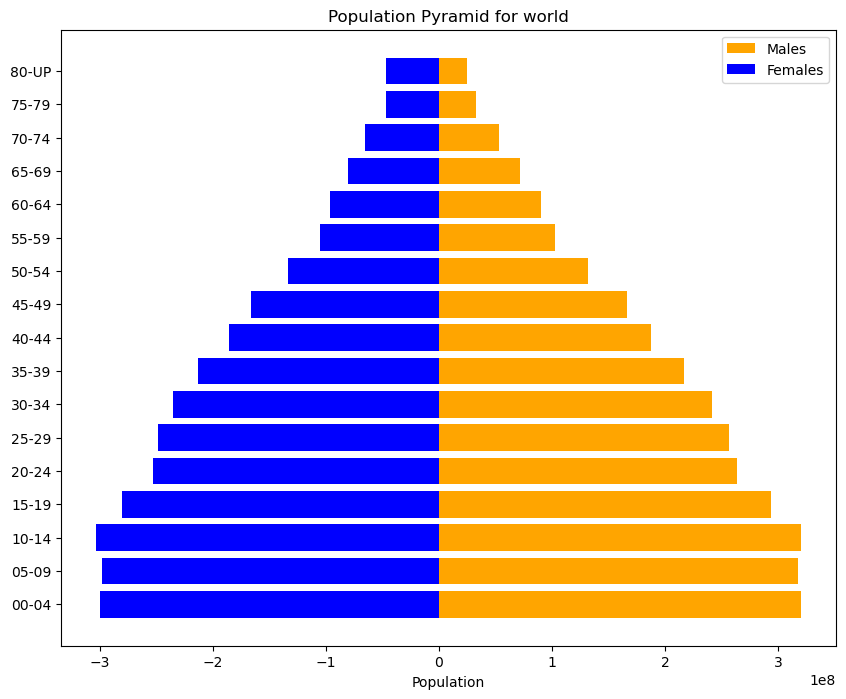

In [10]:
def plot_population_pyramid(df, place):
    
    df_filtered = df
    age_groups = df_filtered['age']
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(age_groups, df_filtered['male'], color='orange', label='Males')
    ax.barh(age_groups, -df_filtered['female'], color='blue', label='Females')
    ax.set_xlabel('Population')
    ax.set_title(f'Population Pyramid for {place}')
    ax.legend()
    plt.show()

plot_population_pyramid(world_pop, 'world')

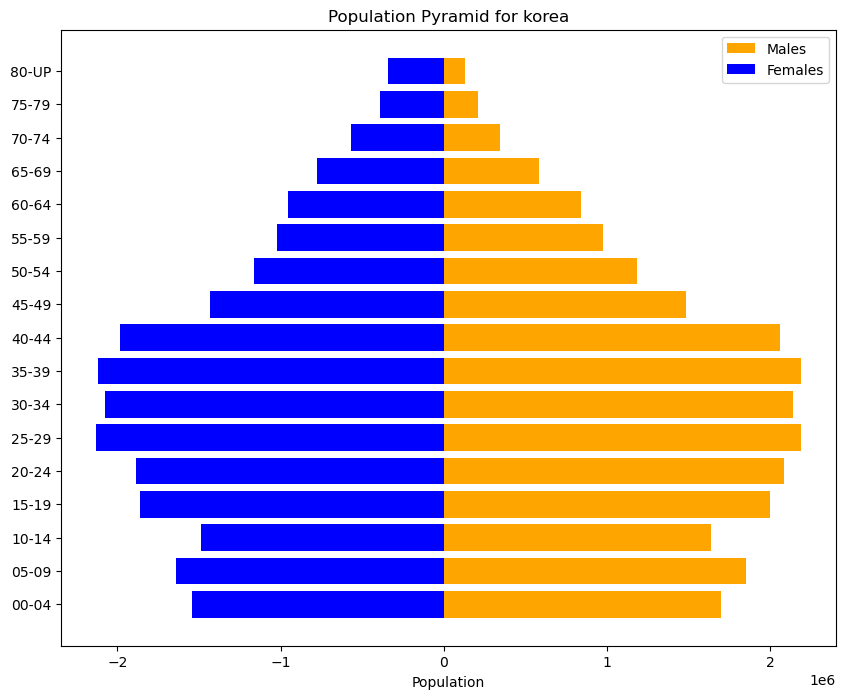

In [11]:
plot_population_pyramid(kor_df, 'korea')

## 4. [C]Other Visualization for Presentation

### 4.1 Rural growth rates by country

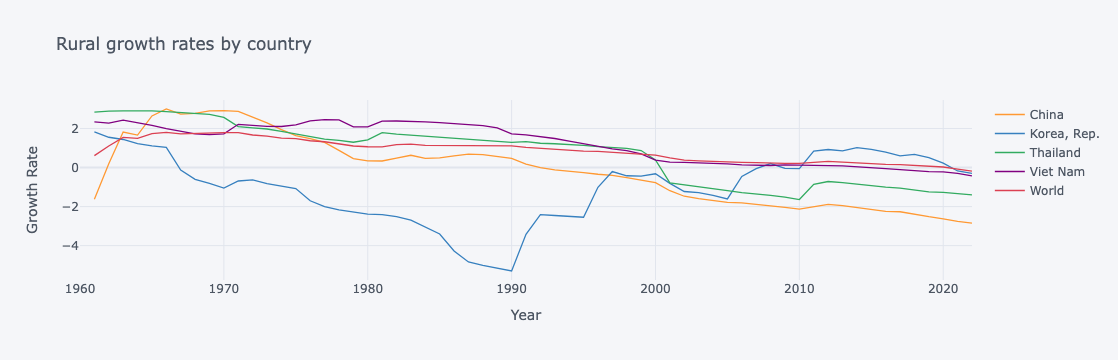

In [12]:
import numpy as np

variable_labels = {"SP.RUR.TOTL.ZG":"Rural population growth (annual %)"
                  }

# Three letter codes come from wbdata.get_country()
countries = {"KOR":"Korea, Rep.",
             "CHN":"China",
             "THA":"Thailand",
             "VNM":"Viet Nam", 
             "WLD":"World"
            }

df = wbdata.get_dataframe(variable_labels, country = countries).squeeze()

df = df.unstack('country')
# Date index is of type string; change to integers
df.index = df.index.astype(int)

# Differences (over time) in logs give us growth rates
df.iplot(title="Rural growth rates by country",
                        yTitle="Growth Rate",xTitle='Year')

### 4.2 Urban growth rates by country

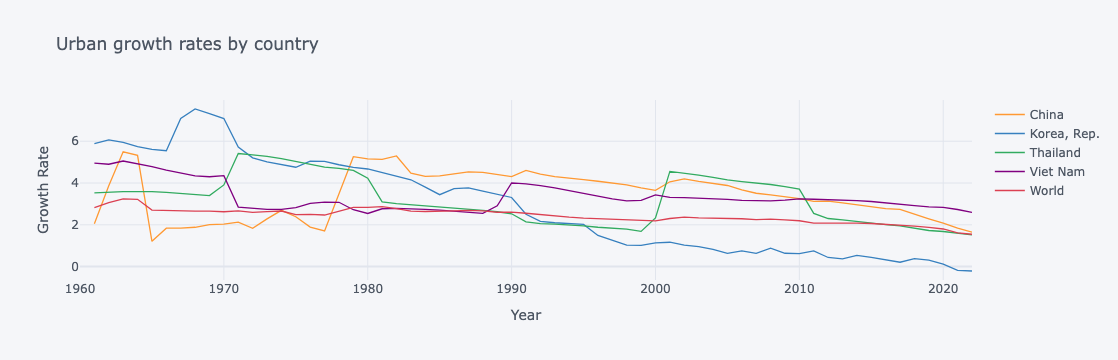

In [13]:
import numpy as np

variable_labels = {"SP.URB.GROW":"Urban population growth (annual %)"
                  }

# Three letter codes come from wbdata.get_country()
countries = {"KOR":"Korea, Rep.",
             "CHN":"China",
             "THA":"Thailand",
             "VNM":"Viet Nam", 
             "WLD":"World"
            }

df = wbdata.get_dataframe(variable_labels, country = countries).squeeze()

df = df.unstack('country')
# Date index is of type string; change to integers
df.index = df.index.astype(int)

# Differences (over time) in logs give us growth rates
df.iplot(title="Urban growth rates by country",
                        yTitle="Growth Rate",xTitle='Year')

### 4.3 Net migration by country

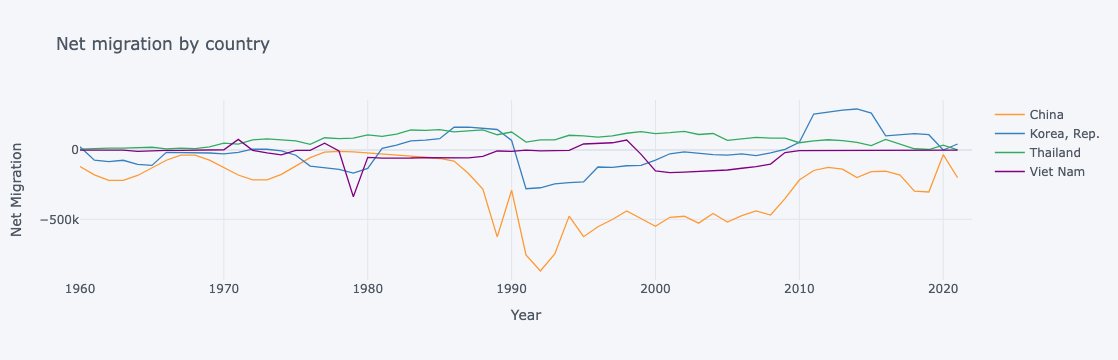

In [14]:
import numpy as np

variable_labels = {"SM.POP.NETM":"Net migration"
                  }

# Three letter codes come from wbdata.get_country()
countries = {"KOR":"Korea, Rep.",
             "CHN":"China",
             "THA":"Thailand",
             "VNM":"Viet Nam"
            }

df = wbdata.get_dataframe(variable_labels, country = countries).squeeze()

df = df.unstack('country')
# Date index is of type string; change to integers
df.index = df.index.astype(int)

# Differences (over time) in logs give us growth rates
df.iplot(title="Net migration by country",
                        yTitle="Net Migration",xTitle='Year')

### 4.4 Birth Rate VS Death Rate

In [15]:
variable_labels = {"SP.POP.TOTL":"KOR Population", 
                   "SP.POP.3539.FE": "Population ages 35-39, female", 
                   "SP.POP.3034.FE": "Population ages 30-34, female", 
                   "SP.POP.2529.FE": "Population ages 25-29, female",
                   "SP.DYN.TFRT.IN": "Fertility rate", 
                   "SP.POP.3539.MA": "Population ages 35-39, male", 
                   "SP.POP.3034.MA": "Population ages 30-34, male", 
                   "SP.POP.2529.MA": "Population ages 25-29, male", 
                   "SP.POP.2024.MA": "Population ages 20-24, male", 
                   "SP.POP.GROW": "Population growth (annual %)", 
                   "SH.DYN.MORT": "Mortality rate, under-5 (per 1,000 live births)",
                   "SP.DYN.CBRT.IN": "Birth rate, crude (per 1,000 people)"}       
KOR = wbdata.get_dataframe(variable_labels, country="KOR")
KOR.index = KOR.index.astype(int)

In [16]:
birth_mortality = KOR[['Birth rate, crude (per 1,000 people)', 'Mortality rate, under-5 (per 1,000 live births)']].sort_index()
birth_mortality

,"Birth rate, crude (per 1,000 people)","Mortality rate, under-5 (per 1,000 live births)"
date,,
1960,41.930,111.9
1961,40.983,106.5
1962,39.657,101.8
1963,38.083,96.9
1964,36.448,92.0
...,...,...
2018,6.400,3.2
2019,5.900,3.1
2020,5.300,3.0


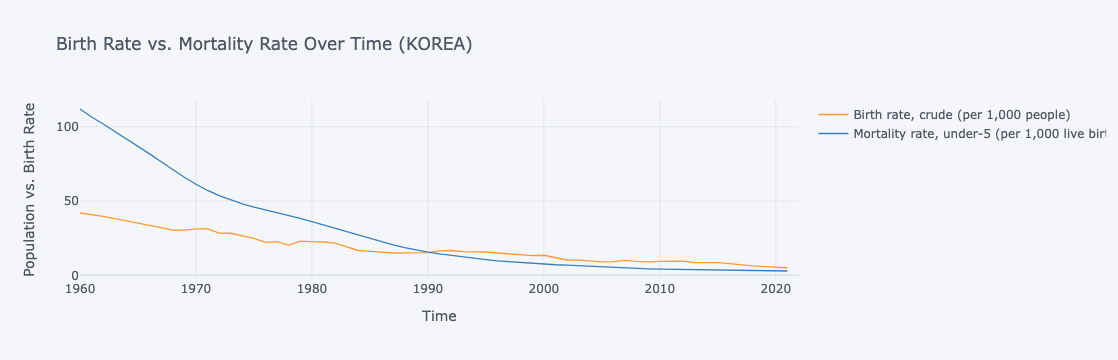

In [17]:
birth_mortality.iplot(title="Birth Rate vs. Mortality Rate Over Time (KOREA)",xTitle='Time',yTitle='Population vs. Birth Rate')

### 4.6 Birth Rate VS GDP per Capita

In [18]:
variablelabels = {"NY.GDP.PCAP.CD":"GDP per capita (current US$)", "NY.GDP.PCAP.KD.ZG": "GDP per capita growth (annual %)"}

KORECON = wbdata.get_dataframe(variablelabels, country="KOR")

# Date index is of type string; change to integers
KORECON.index = KORECON.index.astype(int)

# Print a few years' data
KORECON=KORECON.sort_index()
KORECON.index=KORECON.index.astype(int)
df=birth_mortality.join(KORECON)


In [ ]:
%pip install pandas==1.5.2

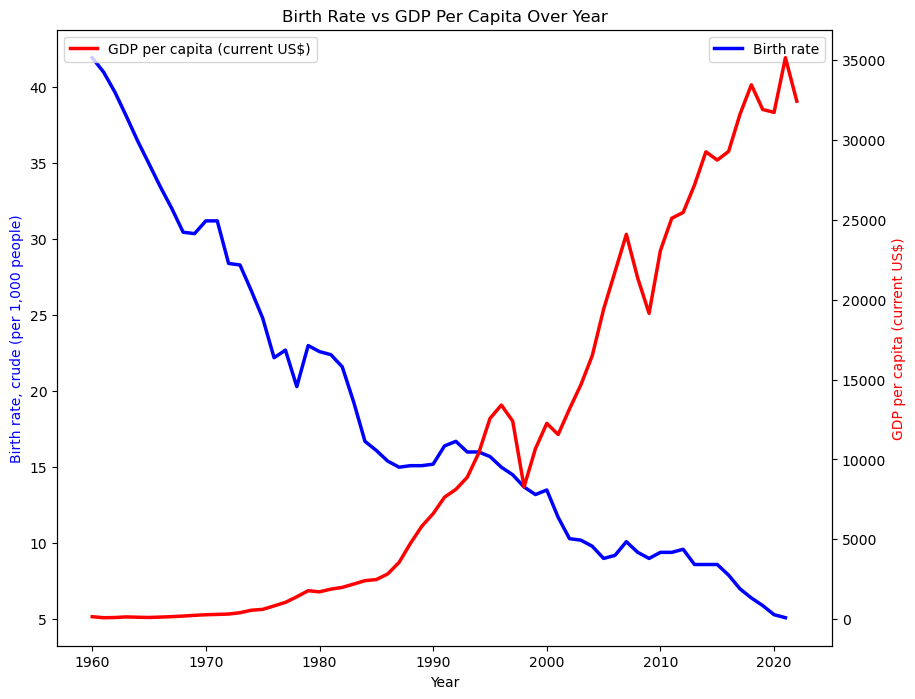

In [19]:
plt.figure(figsize=(10, 8))

ax1 = plt.gca()  # Get the current axes
ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
# Plot the birth rate on the left y-axis (ax1)
sns.lineplot(data=df, x='date', y='Birth rate, crude (per 1,000 people)', 
             label='Birth rate', color='blue', linewidth=2.5, ax=ax1)

# Plot the GDP per capita growth on the right y-axis (ax2)
sns.lineplot(data=df, x='date', y='GDP per capita (current US$)',
             label='GDP per capita (current US$)', color='red', linewidth=2.5, ax=ax2)

ax1.set_xlabel('Year')
ax1.set_ylabel('Birth rate, crude (per 1,000 people)', color='blue')
ax2.set_ylabel('GDP per capita (current US$)', color='red')
plt.title("Birth Rate vs GDP Per Capita Over Year")
plt.show();

# 5. [C] Agricultural Production

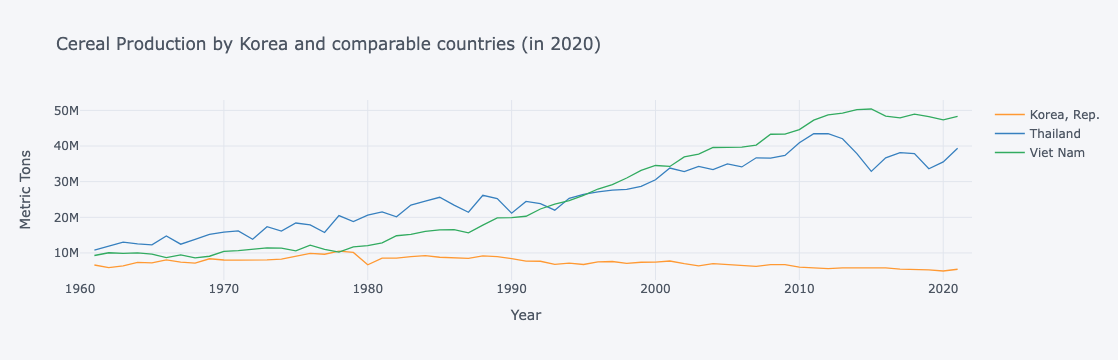

In [20]:
#[C]Agricultural Production
def fix_date_index(df):
    idx_vars = df.index.names
    new = df.reset_index()
    new.date = new.date.astype(int)
    return new.set_index(idx_vars)


vars = {"AG.PRD.CREL.MT":"Cereal production"}
use=["KOR","THA","VNM"]

cereals = fix_date_index(wbdata.get_dataframe(vars,country=use)).squeeze().unstack('country')
# Use this to find top producers:
#big_producers = cereals.query('date==2020').squeeze().sort_values(ascending=False)
#big_producers.head(20)

cereals.iplot(xTitle="Year",yTitle="Metric Tons",
              title="Cereal Production by Korea and comparable countries (in 2020)")

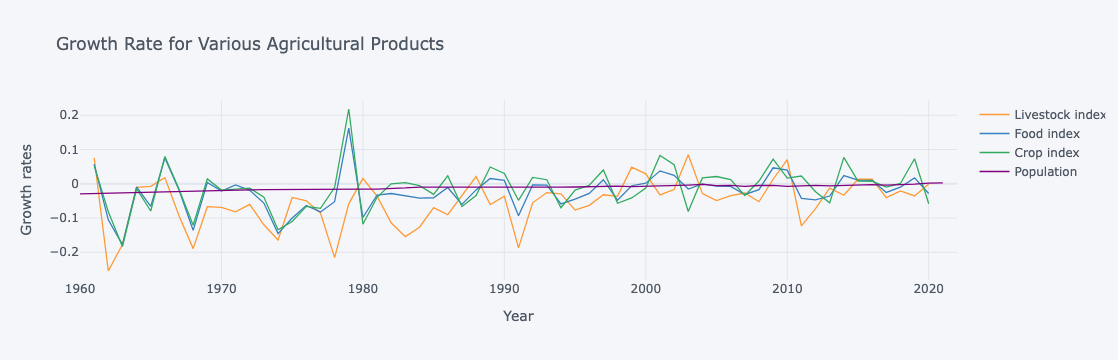

In [21]:
#GROWTH RATE OF LIVESTOCK, FOOD, CROPS, AND POPULATION
#get variables for livestock/food/crop index and overall population
vars = {"AG.PRD.LVSK.XD":"Livestock index",
        "AG.PRD.FOOD.XD":"Food index",
        "AG.PRD.CROP.XD":"Crop index",
        "SP.POP.TOTL":"Population"}

food_GBR = fix_date_index(wbdata.get_dataframe(vars,country='KOR'))

food_GBR

# calculate and plot growth rates using diff and log
np.log(food_GBR).diff().iplot(xTitle="Year",yTitle="Growth rates", title="Growth Rate for Various Agricultural Products")

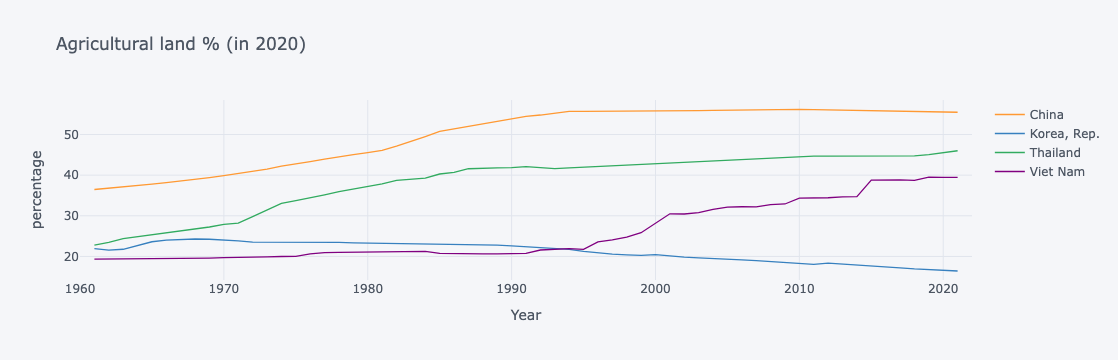

In [22]:
vars = {"AG.LND.AGRI.ZS":"AGRICULTURAL LAND PERCENTAGE"}


use=["KOR","CHN","THA","VNM"]

agricultural_land = fix_date_index(wbdata.get_dataframe(vars,country=use)).squeeze().unstack('country')

agricultural_land.iplot(xTitle="Year",yTitle="percentage",
              title="Agricultural land % (in 2020)")

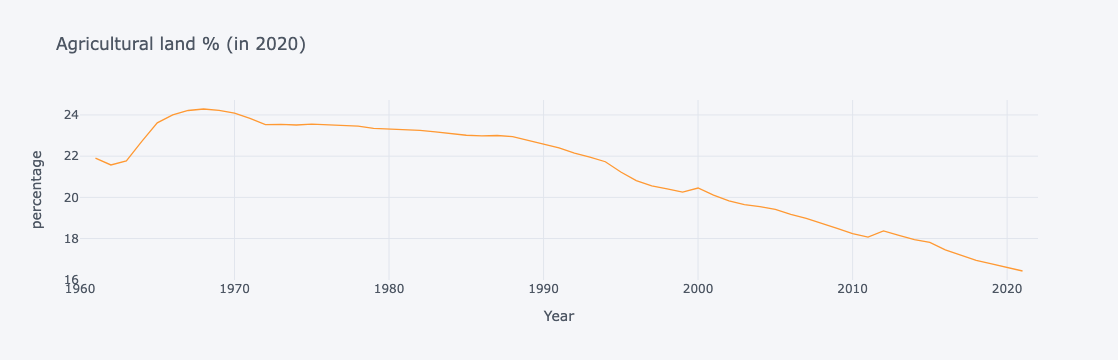

In [23]:
vars = {"AG.LND.AGRI.ZS":"AGRICULTURAL LAND PERCENTAGE"}


use=["KOR"]

agricultural_land = fix_date_index(wbdata.get_dataframe(vars,country=use)).squeeze()

agricultural_land.iplot(xTitle="Year",yTitle="percentage",
              title="Agricultural land % (in 2020)")

In [24]:
variablelabels = {"AG.LND.AGRI.ZS":"Agricultural land (% of land area)", "NY.GDP.PCAP.CD":"GDP per capita (current US$)"}
KORECON = wbdata.get_dataframe(variablelabels, country="KOR")

# Print a few years' data
KORECON=KORECON.sort_index() 

KORECON.index=KORECON.index.astype(int)
KORECON

,Agricultural land (% of land area),GDP per capita (current US$)
date,,
1960,NaN,158.274136
1961,21.905453,93.831383
1962,21.573709,106.159703
1963,21.770682,146.302493
1964,22.714078,123.606374
...,...,...
2018,16.940115,33447.156284
2019,16.772541,31902.416905
2020,16.608607,31721.298914


/srv/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 9 (	) missing from current font.



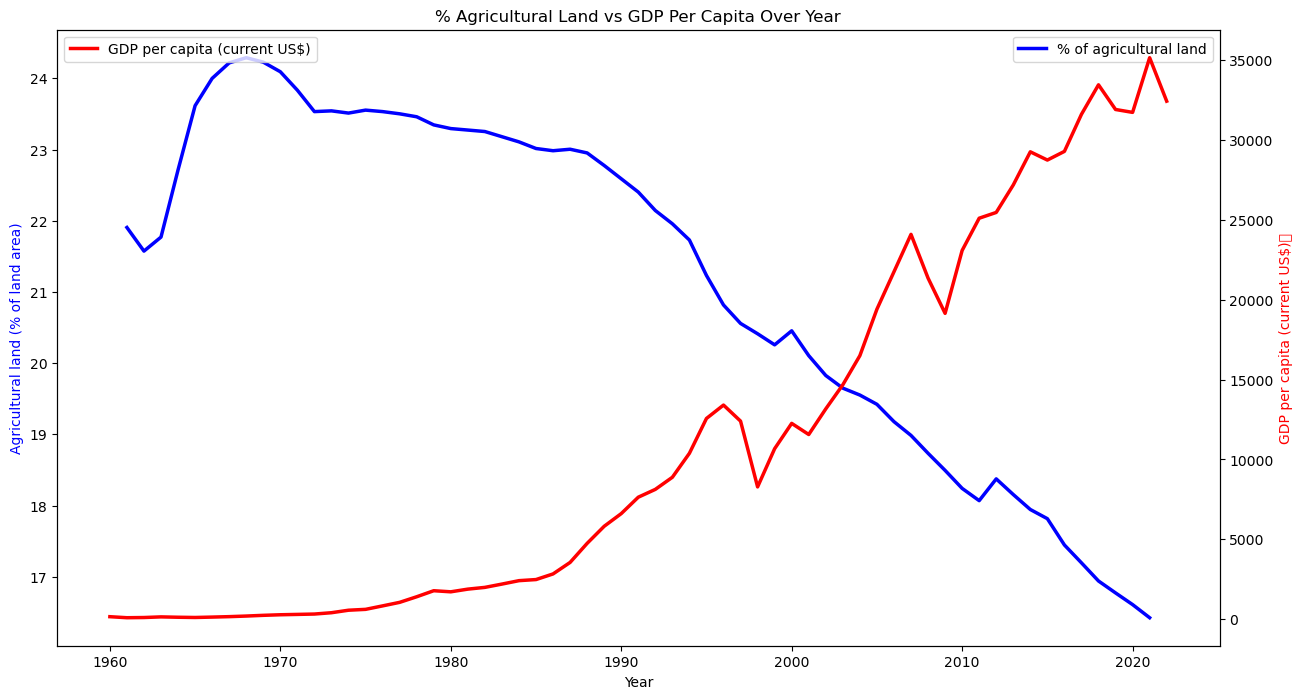

In [25]:
plt.figure(figsize=(15, 8))

ax1 = plt.gca()  # Get the current axes
ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis

# Plot the birth rate on the left y-axis (ax1)
sns.lineplot(data=KORECON, x='date', y='Agricultural land (% of land area)', 
             label='% of agricultural land', color='blue', linewidth=2.5, ax=ax1)

# Plot the GDP per capita growth on the right y-axis (ax2)
sns.lineplot(data=KORECON, x='date', y='GDP per capita (current US$)',
             label='GDP per capita (current US$)', color='red', linewidth=2.5, ax=ax2)

ax1.set_xlabel('Year')
ax1.set_ylabel('Agricultural land (% of land area)', color='blue')
ax2.set_ylabel('GDP per capita (current US$)	', color='red')
plt.title("% Agricultural Land vs GDP Per Capita Over Year")
plt.show()

## 6. [C] Population Maps

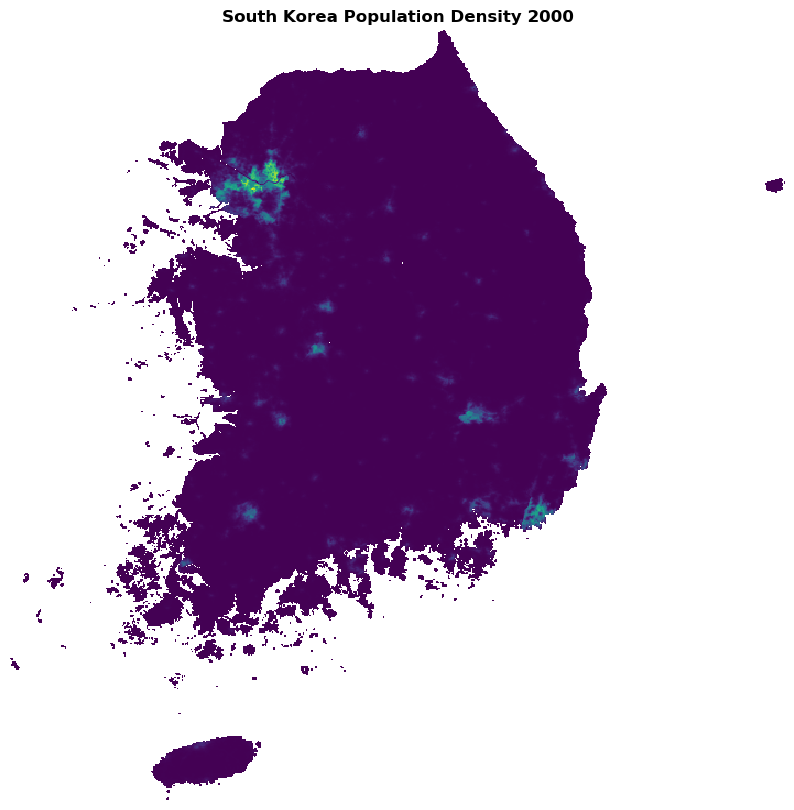

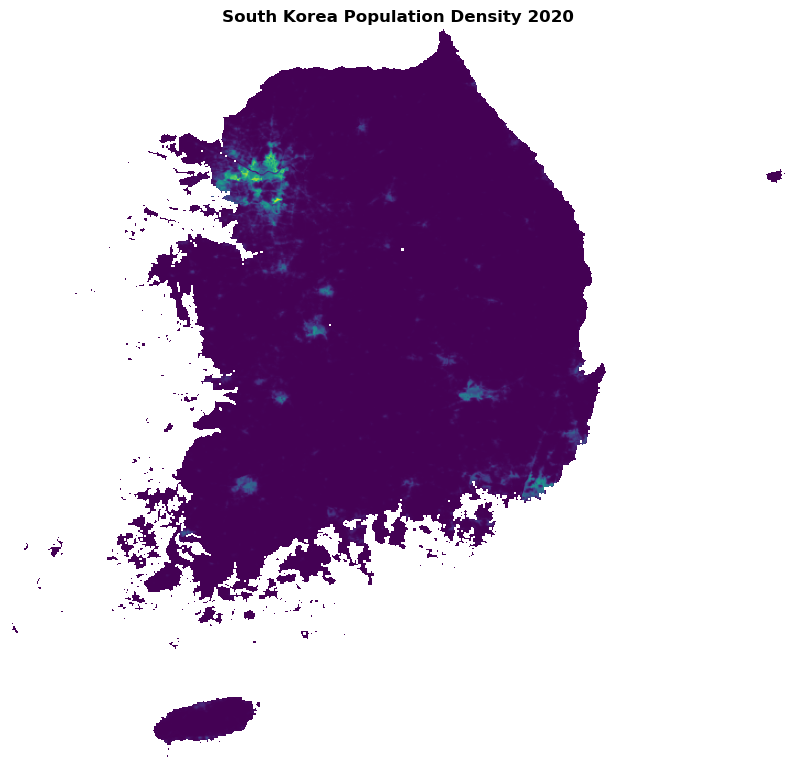

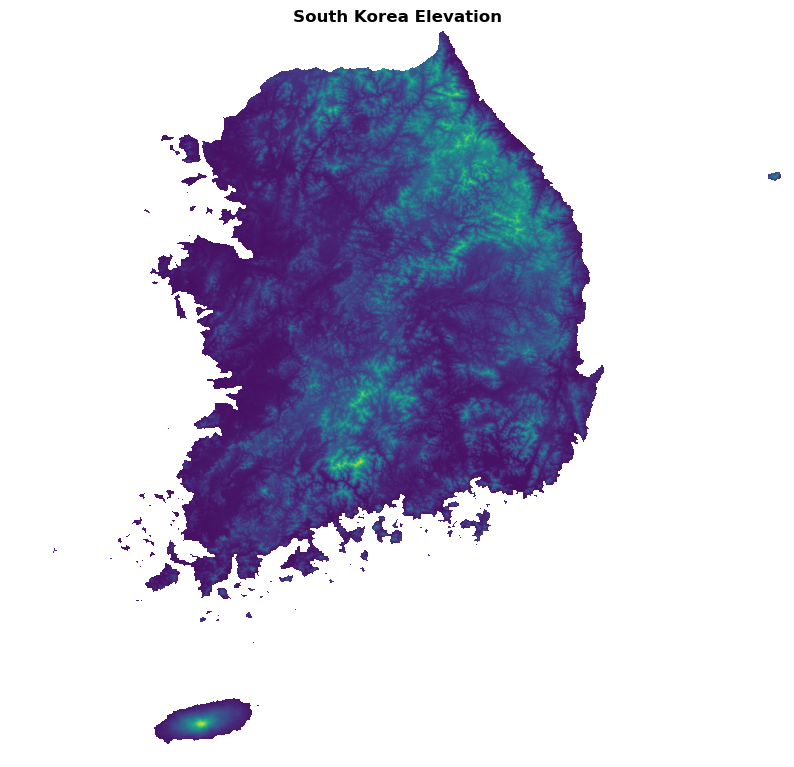

In [7]:
from IPython.display import display, HTML
display(HTML("<style>.output_scroll { height: auto !important; max-height: none !important; }</style>"))


#%pip install geopandas
#print("")
import geopandas as gpd
import rasterio
import rasterio.plot
import numpy as np

kor_pd_2000 = rasterio.open('kor_pd_2000_1km.tif')
kor_pd_2020 = rasterio.open('kor_pd_2020_1km.tif')
kor_elev = rasterio.open('kor_srtm_topo_100m.tif')


fig1, ax1 = plt.subplots(figsize=(10,10))
rasterio.plot.show(kor_pd_2000, 
                   ax=ax1,
                   cmap='viridis',
                   title='South Korea Population Density 2000',
                   interpolation = 'nearest',
                   aspect = 'auto').set_axis_off()

fig, ax = plt.subplots(figsize=(10,10))
rasterio.plot.show(kor_pd_2020, 
                   ax=ax, 
                   cmap='viridis',      
                   title='South Korea Population Density 2020').set_axis_off()

fig2, ax2 = plt.subplots(figsize=(10,10))
rasterio.plot.show(kor_elev, 
                   ax=ax2, 
                   cmap='viridis',      
                   title='South Korea Elevation').set_axis_off()

print('')